In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo
import warnings
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime

# Suppress the PyTorch deprecation warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [110]:
image_path = 'dss_2205/image/'
data_path = 'dss_2205/hardness_table.csv'

In [111]:
# image augmentations
train_argumentations = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

test_argumentations = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

In [ ]:
# dataset perparation
# class IM2PROPDataset(Dataset):
#     def __init__(self, csv_data, image_dir, transform=None):
#         self.data = csv_data.reset_index(drop=True)
#         self.img_dir = image_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         img_name = self.data.iloc[idx, 0]
#         img_path = os.path.join(self.img_dir, f"{img_name}.png")
#         target = self.data.iloc[idx, 2]


#         image = Image.open(img_path).convert("RGB")
#         if self.transform:
#             image = self.transform(image)
        
#         target = torch.tensor(target, dtype=torch.float32)
#         return image, target

class IM2PROPDataset(Dataset):
    """
    Tiles each 768x768 image into 4 patches of 384x384 (TL, TR, BL, BR).
    Target value is copied to all patches.
    """
    # 4 quadrants (left, top, right, bottom)
    # using this to increase dataset size
    BOXES = [
        (0,   0,   384, 384),  # top-left  -> patch_id 0
        (384, 0,   768, 384),  # top-right -> patch_id 1
        (0,   384, 384, 768),  # bottom-left -> patch_id 2
        (384, 384, 768, 768),  # bottom-right-> patch_id 3
    ]

    def __init__(self, csv_data, image_dir, transform=None, return_info=False):
        # Expect columns: image_id, avg_hardness, avg_hardness_round
        self.data = csv_data.reset_index(drop=True)
        self.img_dir = image_dir
        self.transform = transform
        self.return_info = return_info  # if True, also return (img_name, patch_id)

    def __len__(self):
        # 4 tiles per base image
        return len(self.data) * 4

    def __getitem__(self, idx):
        base_idx = idx // 4        # which base image
        patch_id = idx % 4         # which quadrant

        img_name = self.data.iloc[base_idx, 0]  # 'image_id'
        target   = self.data.iloc[base_idx, 2]  # 'avg_hardness_round'
        img_path = os.path.join(self.img_dir, f"{img_name}.png")

        image = Image.open(img_path).convert("RGB")
        tile  = image.crop(self.BOXES[patch_id])  # 384x384

        if self.transform:
            tile = self.transform(tile)

        target = torch.tensor(target, dtype=torch.float32)

        if self.return_info:
            return tile, target, (img_name, patch_id)
        return tile, target

In [113]:
df = pd.read_csv(data_path)

random_state = random.randint(0, 10000)

train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=random_state)

train_dataset = IM2PROPDataset(train_df, image_dir=image_path, transform=train_argumentations)
val_dataset = IM2PROPDataset(val_df, image_dir=image_path, transform=test_argumentations)
test_dataset = IM2PROPDataset(test_df, image_dir=image_path, transform=test_argumentations)

print(f"Train images: {len(train_dataset)}")
print(f"Val images  : {len(val_dataset)}")
print(f"Test images : {len(test_dataset)}")
print(f"Total       : {len(train_dataset)+len(val_dataset)+len(test_dataset)}")

Train images: 152
Val images  : 40
Test images : 48
Total       : 240


In [114]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [115]:
# --- 1. Define the Custom Regression Head (Decoder) ---
class RegressionHead(nn.Module):
    """
    The decoder part of the model, which performs aggregation and
    final dimensionality reduction from the 2048 feature channels to a single scalar.
    """
    def __init__(self, final_output_dim=1):
        super().__init__()
        
        # Spatial Aggregation: Global Average Pooling (GAP)
        # Input: [B, 2048, H, W] -> Output: [B, 2048, 1, 1]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Channel-wise Dimensionality Reduction: Linear Layers
        self.regressor = nn.Sequential(
            # Input size is 2048 (from GAP)
            nn.Linear(2048, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512), 
            nn.BatchNorm1d(512),
            nn.ReLU(),
            # nn.Dropout(0.5),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, final_output_dim)  # Final output layer
        )

    def forward(self, x):
        # x shape: [B, 2048, H, W]
        x = self.avgpool(x)       # Shape: [B, 2048, 1, 1]
        x = torch.flatten(x, 1)   # Shape: [B, 2048] (The latent feature vector)
        output = self.regressor(x)
        
        return output

# --- 2. Define the Complete Model Wrapper ---
class MicroNetRegressor(nn.Module):
    """
    Combines the pre-trained ResNet encoder features with the new Regression Head.
    """
    def __init__(self, pre_trained_base_model):
        super().__init__()
        
        # --- ENCODER (The pre-trained feature extractor) ---
        # We explicitly assemble the layers that constitute the ResNet feature backbone.
        # This excludes the original 'avgpool' and 'fc' classification layers.
        self.encoder_features = nn.Sequential(
            pre_trained_base_model.conv1, 
            pre_trained_base_model.bn1, 
            pre_trained_base_model.relu, 
            pre_trained_base_model.maxpool, 
            pre_trained_base_model.layer1, 
            pre_trained_base_model.layer2, 
            pre_trained_base_model.layer3, 
            pre_trained_base_model.layer4
        )
        
        # --- DECODER / REGRESSION HEAD (The new, trainable part) ---
        self.regression_head = RegressionHead(final_output_dim=1)

    def forward(self, x):
        # 1. Pass input through the pre-trained encoder
        x = self.encoder_features(x)  # Output is the deep feature map: [B, 2048, H, W]
        
        # 2. Pass feature map through the custom head for regression
        output = self.regression_head(x) # Output is the scalar prediction: [B, 1]
        
        return output
    
# --- 3. Model Initialization and Loading ---

# Configuration
encoder_name = 'resnet50'
weights_source = 'micronet'

print(f"Loading {encoder_name} architecture...")
# Initialize the base PyTorch ResNet-50 model (un-initialized, as we load custom weights later)
# Using weights=None to comply with the new PyTorch API
base_model = torch.hub.load('pytorch/vision:v0.10.0', encoder_name, weights=None)

# Get the URL for the MicroNet pre-trained weights
url = pmm.util.get_pretrained_microscopynet_url(encoder=encoder_name, encoder_weights=weights_source)

print(f"Loading MicroNet weights from: {url}")
# Load the MicroNet state dictionary into the ResNet-50 model
base_model.load_state_dict(model_zoo.load_url(url))

# 4. Instantiate the Final Regression Model
model_regressor = MicroNetRegressor(pre_trained_base_model=base_model)
model_regressor.eval() # Set model to evaluation mode (important for BN layers)

# --- 5. Optional: Freeze the Encoder Layers ---
# Freeze all encoder weights to only train the new regression head initially
for name, param in model_regressor.named_parameters():
    if name.startswith('encoder_features'):
        param.requires_grad = False
    
# Check which parameters are trainable
total_params = sum(p.numel() for p in model_regressor.parameters())
trainable_params = sum(p.numel() for p in model_regressor.parameters() if p.requires_grad)

Loading resnet50 architecture...
Loading MicroNet weights from: https://nasa-public-data.s3.amazonaws.com/microscopy_segmentation_models/resnet50_pretrained_microscopynet_v1.1.pth.tar


Using cache found in /home/jay/.cache/torch/hub/pytorch_vision_v0.10.0


In [116]:
# --- 3. Model Initialization and Loading ---

# Configuration
encoder_name = 'resnet50'
weights_source = 'micronet'

print(f"Loading {encoder_name} architecture...")
# Initialize the base PyTorch ResNet-50 model (un-initialized, as we load custom weights later)
# Using weights=None to comply with the new PyTorch API
base_model = torch.hub.load('pytorch/vision:v0.10.0', encoder_name, weights=None)

# Get the URL for the MicroNet pre-trained weights
url = pmm.util.get_pretrained_microscopynet_url(encoder=encoder_name, encoder_weights=weights_source)

print(f"Loading MicroNet weights from: {url}")
# Load the MicroNet state dictionary into the ResNet-50 model
base_model.load_state_dict(model_zoo.load_url(url))

# 4. Instantiate the Final Regression Model
model_regressor = MicroNetRegressor(pre_trained_base_model=base_model)

# --- 5. Optional: Freeze the Encoder Layers ---
# Freeze all encoder weights to only train the new regression head initially
for name, param in model_regressor.named_parameters():
    if name.startswith('encoder_features'):
        param.requires_grad = False
    
# Check which parameters are trainable
total_params = sum(p.numel() for p in model_regressor.parameters())
trainable_params = sum(p.numel() for p in model_regressor.parameters() if p.requires_grad)

print("\n--- Model Summary ---")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters (Regression Head): {trainable_params:,}")
print(f"Encoder Layers Frozen: {total_params - trainable_params:,}")

Loading resnet50 architecture...
Loading MicroNet weights from: https://nasa-public-data.s3.amazonaws.com/microscopy_segmentation_models/resnet50_pretrained_microscopynet_v1.1.pth.tar


Using cache found in /home/jay/.cache/torch/hub/pytorch_vision_v0.10.0



--- Model Summary ---
Total Parameters: 26,200,129
Trainable Parameters (Regression Head): 2,692,097
Encoder Layers Frozen: 23,508,032


In [ ]:
model_regressor = model_regressor.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_regressor.parameters()), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # optional

In [118]:
# --- 3. Training Loop ---
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    
    for images, targets in tqdm(dataloader, desc="Training", leave=False):
        images, targets = images.to(device), targets.to(device).unsqueeze(1)  # [B, 1]
        
        optimizer.zero_grad()
        outputs = model(images)              # forward pass -> [B, 1]
        loss = criterion(outputs, targets)   # MSE loss
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    preds, trues = [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Validation", leave=False):
            images, targets = images.to(device), targets.to(device).unsqueeze(1)
            outputs = model(images)
            
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    preds_scaled = np.concatenate(preds).squeeze()
    trues_scaled = np.concatenate(trues).squeeze()

    mse = np.mean((preds_scaled - trues_scaled) ** 2)
    mae = np.mean(np.abs(preds_scaled - trues_scaled))
    r2 = 1 - (np.sum((preds_scaled - trues_scaled) ** 2) / (np.sum((trues_scaled - np.mean(trues_scaled)) ** 2) + 1e-8))

    return epoch_loss, mae, mse, r2


Epoch [1/50]


Train Loss: 3.8061 | Val Loss: 4.1901 | Val MAE: 2.0135 | Val MSE: 4.1901 | Val R²: -72.6334
✅ Saved new best model

Epoch [2/50]


Train Loss: 0.9209 | Val Loss: 1.3282 | Val MAE: 1.1230 | Val MSE: 1.3282 | Val R²: -22.3397
✅ Saved new best model

Epoch [3/50]


Train Loss: 0.1138 | Val Loss: 0.0766 | Val MAE: 0.2365 | Val MSE: 0.0766 | Val R²: -0.3464
✅ Saved new best model

Epoch [4/50]


Train Loss: 0.0869 | Val Loss: 0.0520 | Val MAE: 0.1921 | Val MSE: 0.0520 | Val R²: 0.0862
✅ Saved new best model

Epoch [5/50]


Train Loss: 0.0971 | Val Loss: 0.3062 | Val MAE: 0.5045 | Val MSE: 0.3062 | Val R²: -4.3808

Epoch [6/50]


Train Loss: 0.0585 | Val Loss: 0.0771 | Val MAE: 0.2302 | Val MSE: 0.0771 | Val R²: -0.3545

Epoch [7/50]


Train Loss: 0.0479 | Val Loss: 0.0266 | Val MAE: 0.1350 | Val MSE: 0.0266 | Val R²: 0.5332
✅ Saved new best model

Epoch [8/50]


Train Loss: 0.0266 | Val Loss: 0.0040 | Val MAE: 0.0527 | Val MSE: 0.0040 | Val R²: 0.9299
✅ Saved new best model

Epoch [9/50]


Train Loss: 0.0297 | Val Loss: 0.0232 | Val MAE: 0.1383 | Val MSE: 0.0232 | Val R²: 0.5919

Epoch [10/50]


Train Loss: 0.0318 | Val Loss: 0.0275 | Val MAE: 0.1228 | Val MSE: 0.0275 | Val R²: 0.5172

Epoch [11/50]


Train Loss: 0.0440 | Val Loss: 0.0255 | Val MAE: 0.1352 | Val MSE: 0.0255 | Val R²: 0.5520

Epoch [12/50]


Train Loss: 0.0295 | Val Loss: 0.0465 | Val MAE: 0.1764 | Val MSE: 0.0465 | Val R²: 0.1829

Epoch [13/50]


Train Loss: 0.0462 | Val Loss: 0.0489 | Val MAE: 0.1964 | Val MSE: 0.0489 | Val R²: 0.1403

Epoch [14/50]


Train Loss: 0.0466 | Val Loss: 0.0476 | Val MAE: 0.1737 | Val MSE: 0.0476 | Val R²: 0.1640

Epoch [15/50]


Train Loss: 0.0355 | Val Loss: 0.0317 | Val MAE: 0.1255 | Val MSE: 0.0317 | Val R²: 0.4428

Epoch [16/50]


Train Loss: 0.0298 | Val Loss: 0.0195 | Val MAE: 0.1249 | Val MSE: 0.0195 | Val R²: 0.6571

Epoch [17/50]


Train Loss: 0.0269 | Val Loss: 0.0228 | Val MAE: 0.1384 | Val MSE: 0.0228 | Val R²: 0.5985

Epoch [18/50]


Train Loss: 0.0222 | Val Loss: 0.0263 | Val MAE: 0.1187 | Val MSE: 0.0263 | Val R²: 0.5376

Epoch [19/50]


Train Loss: 0.0309 | Val Loss: 0.0923 | Val MAE: 0.2280 | Val MSE: 0.0923 | Val R²: -0.6221

Epoch [20/50]


Train Loss: 0.0211 | Val Loss: 0.0489 | Val MAE: 0.1704 | Val MSE: 0.0489 | Val R²: 0.1408

Epoch [21/50]


Train Loss: 0.0291 | Val Loss: 0.0555 | Val MAE: 0.1979 | Val MSE: 0.0555 | Val R²: 0.0245

Epoch [22/50]


Train Loss: 0.0273 | Val Loss: 0.0503 | Val MAE: 0.2031 | Val MSE: 0.0503 | Val R²: 0.1166

Epoch [23/50]


Train Loss: 0.0302 | Val Loss: 0.0182 | Val MAE: 0.1097 | Val MSE: 0.0182 | Val R²: 0.6808

Epoch [24/50]


Train Loss: 0.0207 | Val Loss: 0.0069 | Val MAE: 0.0650 | Val MSE: 0.0069 | Val R²: 0.8782

Epoch [25/50]


Train Loss: 0.0273 | Val Loss: 0.0439 | Val MAE: 0.1609 | Val MSE: 0.0439 | Val R²: 0.2285

Epoch [26/50]


Train Loss: 0.0192 | Val Loss: 0.0063 | Val MAE: 0.0640 | Val MSE: 0.0063 | Val R²: 0.8900

Epoch [27/50]


Train Loss: 0.0375 | Val Loss: 0.0534 | Val MAE: 0.2255 | Val MSE: 0.0534 | Val R²: 0.0622

Epoch [28/50]


Train Loss: 0.0295 | Val Loss: 0.0132 | Val MAE: 0.0861 | Val MSE: 0.0132 | Val R²: 0.7673

Epoch [29/50]


Train Loss: 0.0135 | Val Loss: 0.0443 | Val MAE: 0.1830 | Val MSE: 0.0443 | Val R²: 0.2224

Epoch [30/50]


Train Loss: 0.0174 | Val Loss: 0.0332 | Val MAE: 0.1499 | Val MSE: 0.0332 | Val R²: 0.4157

Epoch [31/50]


Train Loss: 0.0140 | Val Loss: 0.0055 | Val MAE: 0.0578 | Val MSE: 0.0055 | Val R²: 0.9028

Epoch [32/50]


Train Loss: 0.0285 | Val Loss: 0.0354 | Val MAE: 0.1471 | Val MSE: 0.0354 | Val R²: 0.3778

Epoch [33/50]


Train Loss: 0.0189 | Val Loss: 0.1167 | Val MAE: 0.2380 | Val MSE: 0.1167 | Val R²: -1.0516

Epoch [34/50]


Train Loss: 0.0230 | Val Loss: 0.0227 | Val MAE: 0.1246 | Val MSE: 0.0227 | Val R²: 0.6008

Epoch [35/50]


Train Loss: 0.0207 | Val Loss: 0.0106 | Val MAE: 0.0861 | Val MSE: 0.0106 | Val R²: 0.8129

Epoch [36/50]


Train Loss: 0.0192 | Val Loss: 0.0347 | Val MAE: 0.1715 | Val MSE: 0.0347 | Val R²: 0.3904

Epoch [37/50]


Train Loss: 0.0209 | Val Loss: 0.0274 | Val MAE: 0.1438 | Val MSE: 0.0274 | Val R²: 0.5183

Epoch [38/50]


Train Loss: 0.0157 | Val Loss: 0.0495 | Val MAE: 0.1831 | Val MSE: 0.0495 | Val R²: 0.1301

Epoch [39/50]


Train Loss: 0.0415 | Val Loss: 0.0239 | Val MAE: 0.1301 | Val MSE: 0.0239 | Val R²: 0.5803

Epoch [40/50]


Train Loss: 0.0353 | Val Loss: 0.0243 | Val MAE: 0.1454 | Val MSE: 0.0243 | Val R²: 0.5724

Epoch [41/50]


Train Loss: 0.0248 | Val Loss: 0.0062 | Val MAE: 0.0688 | Val MSE: 0.0062 | Val R²: 0.8917

Epoch [42/50]


Train Loss: 0.0190 | Val Loss: 0.0388 | Val MAE: 0.1873 | Val MSE: 0.0388 | Val R²: 0.3179

Epoch [43/50]


Train Loss: 0.0174 | Val Loss: 0.0080 | Val MAE: 0.0684 | Val MSE: 0.0080 | Val R²: 0.8598

Epoch [44/50]


Train Loss: 0.0103 | Val Loss: 0.0174 | Val MAE: 0.1180 | Val MSE: 0.0174 | Val R²: 0.6945

Epoch [45/50]


Train Loss: 0.0137 | Val Loss: 0.0168 | Val MAE: 0.1209 | Val MSE: 0.0168 | Val R²: 0.7051

Epoch [46/50]


Train Loss: 0.0172 | Val Loss: 0.0065 | Val MAE: 0.0537 | Val MSE: 0.0065 | Val R²: 0.8853

Epoch [47/50]


Train Loss: 0.0146 | Val Loss: 0.0365 | Val MAE: 0.1810 | Val MSE: 0.0365 | Val R²: 0.3581

Epoch [48/50]


Train Loss: 0.0175 | Val Loss: 0.0067 | Val MAE: 0.0616 | Val MSE: 0.0067 | Val R²: 0.8825

Epoch [49/50]


Train Loss: 0.0258 | Val Loss: 0.0280 | Val MAE: 0.1535 | Val MSE: 0.0280 | Val R²: 0.5088

Epoch [50/50]


Train Loss: 0.0156 | Val Loss: 0.0150 | Val MAE: 0.1089 | Val MSE: 0.0150 | Val R²: 0.7362

Training complete!


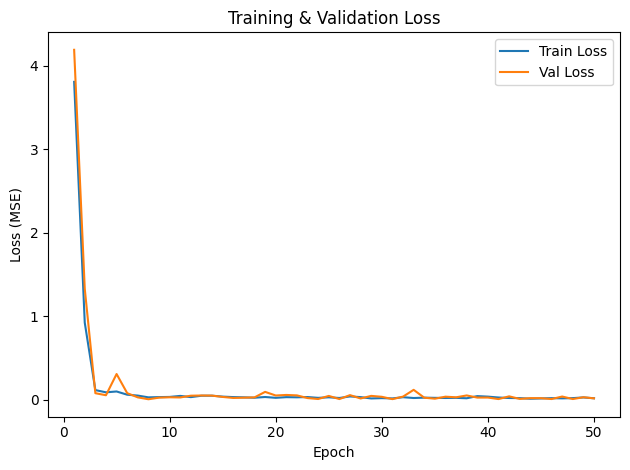

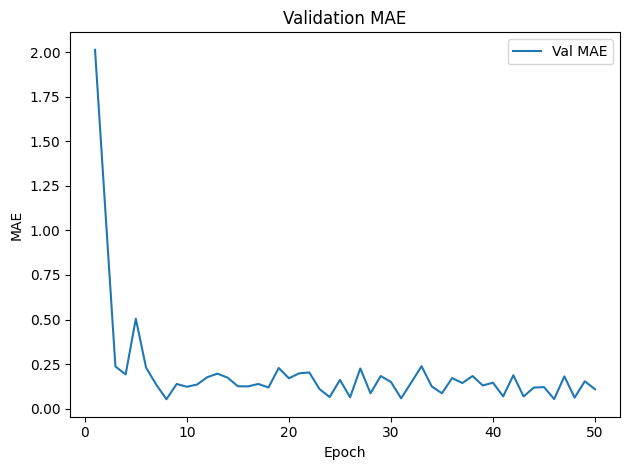

Saved plots: loss_curves.png, val_mae_curve.png


In [119]:
num_epochs = 50
best_val_loss = float('inf')
datetime_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(f"runs/run_{datetime_str}", exist_ok=True)

# histories
hist_train_loss = []
hist_val_loss = []
hist_val_mae  = []

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    train_loss = train_one_epoch(model_regressor, train_loader, optimizer, criterion, device)
    val_loss, val_mae, val_mse, r2 = validate_one_epoch(model_regressor, val_loader, criterion, device)
    
    # Step the scheduler
    # If you're using StepLR / CosineAnnealingLR:
    # scheduler.step()
    # If you're using ReduceLROnPlateau, use this instead:
    # scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Val MSE: {val_mse:.4f} | Val R²: {r2:.4f}")

    # record history
    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)
    hist_val_mae.append(val_mae)
    
    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_regressor.state_dict(), f"runs/run_{datetime_str}/best_regression_model.pt")
        print("✅ Saved new best model")

print("\nTraining complete!")

# ---- Plot curves ----
# Loss curves
plt.figure()
plt.plot(range(1, num_epochs+1), hist_train_loss, label='Train Loss')
plt.plot(range(1, num_epochs+1), hist_val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.tight_layout()
plt.savefig(f'runs/run_{datetime_str}/loss_curves.png', dpi=200)
plt.show()

# (Optional) MAE curve
plt.figure()
plt.plot(range(1, num_epochs+1), hist_val_mae, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Validation MAE')
plt.legend()
plt.tight_layout()
plt.savefig(f'runs/run_{datetime_str}/val_mae_curve.png', dpi=200)
plt.show()

print("Saved plots: loss_curves.png, val_mae_curve.png")


Testing: 100%|██████████| 12/12 [00:00<00:00, 25.31it/s]



--- Test Results ---
MSE : 0.0127
MAE : 0.0895
R²  : 0.8603


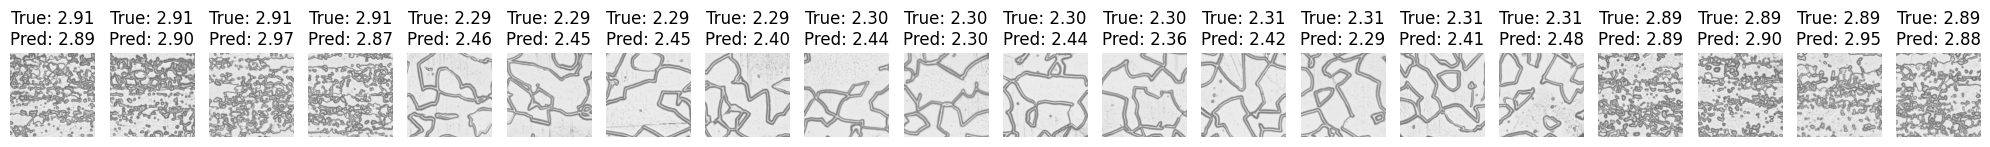

In [125]:
# Load model
model_regressor.load_state_dict(torch.load(f"runs/run_{datetime_str}/best_regression_model.pt", map_location=device))
model_regressor.to(device)
model_regressor.eval()  # VERY IMPORTANT for inference

def test_model(model, dataloader, device):
    model.eval()
    preds, trues, imgs = [], [], []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Testing"):
            images, targets = images.to(device), targets.to(device).unsqueeze(1)
            outputs = model(images)

            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())
            imgs.append(images.cpu().numpy())  # save image batch

    preds_scaled = np.concatenate(preds).squeeze()
    trues_scaled = np.concatenate(trues).squeeze()
    imgs_np = np.concatenate(imgs)

    mse = np.mean((preds_scaled - trues_scaled) ** 2)
    mae = np.mean(np.abs(preds_scaled - trues_scaled))
    r2 = 1 - (np.sum((preds_scaled - trues_scaled) ** 2) / (np.sum((trues_scaled - np.mean(trues_scaled)) ** 2) + 1e-8))

    print("\n--- Test Results ---")
    print(f"MSE : {mse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    return preds_scaled, trues_scaled, imgs_np


# Run test
preds, trues, imgs = test_model(model_regressor, test_loader, device)

# --- Plot some results ---
num_samples = 20  # number of samples to display
plt.figure(figsize=(20, 10))

for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(np.transpose(imgs[i], (1, 2, 0)))
    plt.title(f"True: {trues[i]:.2f}\nPred: {preds[i]:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [126]:
# A. Scale mismatch?
imgs, y = next(iter(train_loader))
with torch.no_grad():
    p = model_regressor(imgs.to(device)).cpu().squeeze()
print("targets range:", y.min().item(), y.max().item())   
print("preds   range:", p.min().item(), p.max().item())    # should be similar scale


targets range: 2.2149999141693115 2.8380000591278076
preds   range: 2.3162052631378174 2.9083049297332764
